# Zadanie domowe
+ Model predykcji zarobków (uwzględniając pozostałe kolumny, grupując je w embeddingi, ważąc klasy, itp.)

## Import, inicjalizacje

In [77]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [79]:
device = torch.device("cuda") 
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device

device(type='cuda')

## Przygotowanie danych

In [80]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)
inp_data = adults_data_orig.copy()
inp_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]
inp_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [81]:
inp_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [82]:
inp_data.sex = (inp_data.sex==' Male').astype(int)
inp_data.label = (inp_data.label==' >50K').astype(int)

In [83]:
inp_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,1,0,0,20,United-States,0


In [84]:
print(inp_data["native-country"].unique())
print(inp_data["race"].unique())

[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']


In [85]:
inp_categorical_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country"]
inp_categorical_values = pd.get_dummies(inp_data[inp_categorical_columns])
inp_categorical_values.head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
inp_data.drop(columns=inp_categorical_columns,inplace=True)

In [87]:
inp_data

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,1,2174,0,40,0
1,50,83311,13,1,0,0,13,0
2,38,215646,9,1,0,0,40,0
3,53,234721,7,1,0,0,40,0
4,28,338409,13,0,0,0,40,0
...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0
32557,40,154374,9,1,0,0,40,1
32558,58,151910,9,0,0,0,40,0
32559,22,201490,9,1,0,0,20,0


In [88]:
inp_data["fnlwgt"] /= (np.max(inp_data["fnlwgt"])/10.0)
inp_data["capital-gain"] /= (np.max(inp_data["capital-gain"])/10.0)

## Podział na zbiory

In [89]:
train_ind = np.random.rand(len(inp_data))>0.3
inp_numerical_data = torch.from_numpy(inp_data.values[train_ind,:-1]).float()
inp_categorical_data = torch.from_numpy(inp_categorical_values.values[train_ind]).float()
inp_targets = torch.from_numpy(inp_data.values[train_ind,-1]).float()

inp_test_numerical_data = torch.from_numpy(inp_data.values[~train_ind,:-1]).float()
inp_test_categorical_data = torch.from_numpy(inp_categorical_values.values[~train_ind]).float()
inp_test_targets = torch.from_numpy(inp_data.values[~train_ind,-1]).float()

inp_train_dataset = data.TensorDataset(inp_numerical_data,inp_categorical_data,inp_targets)
inp_test_dataset = data.TensorDataset(inp_test_numerical_data, inp_test_categorical_data, inp_test_targets)

In [90]:
class Final_adults_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # separated embedding layer kxk processing categorical data
        self.emb_layer = nn.Linear(inp_categorical_data.shape[1], inp_categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(inp_data.shape[1] - 1 + inp_categorical_data.shape[1], 60)
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.6)
        self.layer2 = nn.Linear(60, 30)
        self.act_2 =  nn.ReLU()
        self.d2 = nn.Dropout(0.6)
        self.layer3 = nn.Linear(30, 1)

    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)       # konkatenacja wej i warstwy embeddingu
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [91]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [92]:
inp_model = Final_adults_classifier().to(device)
inp_train_loader = torch.utils.data.DataLoader(inp_train_dataset, batch_size=64, shuffle=True)
inp_test_loader = torch.utils.data.DataLoader(inp_test_dataset, batch_size=128, shuffle=False)
inp_criterion = nn.BCEWithLogitsLoss(pos_weight=(len(inp_targets)-sum(inp_targets))/sum(inp_targets))
inp_optimizer = optim.Adam(inp_model.parameters(), lr=0.001, weight_decay=0.005)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(15):
    epoch_losses = []
    for x, cat_x, labels in iter(inp_train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        inp_model.train() 
        out = inp_model(x, cat_x).squeeze()           

        loss = inp_criterion(out, labels)
        loss.backward()  
        epoch_losses.append(loss.item())
        inp_optimizer.step()              
        inp_optimizer.zero_grad()         

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(inp_model, inp_test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(inp_model, inp_train_loader)) # compute training accuracy 
    val_acc.append(test_acc)  # compute validation accuracy
        

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 1.3 test_acc: 0.714
Epoch 1 loss 0.804 test_acc: 0.737
Epoch 2 loss 0.75 test_acc: 0.77
Epoch 3 loss 0.727 test_acc: 0.766
Epoch 4 loss 0.715 test_acc: 0.753
Epoch 5 loss 0.699 test_acc: 0.795
Epoch 6 loss 0.704 test_acc: 0.759
Epoch 7 loss 0.694 test_acc: 0.783
Epoch 8 loss 0.685 test_acc: 0.804
Epoch 9 loss 0.681 test_acc: 0.824
Epoch 10 loss 0.687 test_acc: 0.796
Epoch 11 loss 0.685 test_acc: 0.796
Epoch 12 loss 0.679 test_acc: 0.803
Epoch 13 loss 0.669 test_acc: 0.713
Epoch 14 loss 0.676 test_acc: 0.804
Final Training Accuracy: 0.8041608146067416
Final Validation Accuracy: 0.8036207425590672


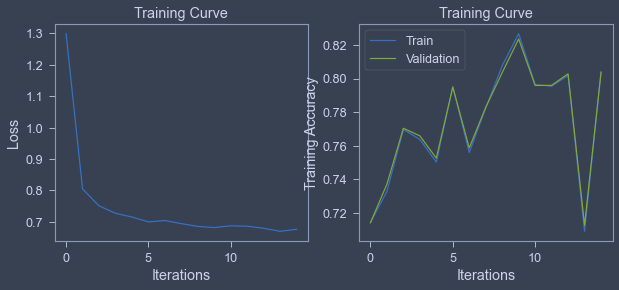

In [93]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

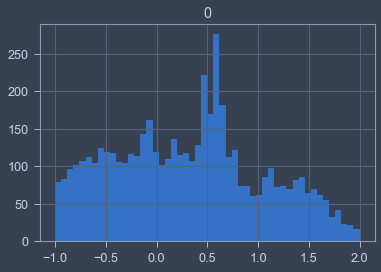

In [94]:
preds = inp_model(inp_test_numerical_data.to(device),inp_test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-1,2));

In [95]:
(preds>0).sum()

tensor(3408, device='cuda:0')